In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# load data
df = pd.read_csv('data.csv', index_col = 0)
# convert date to datetime
df.date = pd.to_datetime(df.date)
# rename columns
df.columns = ['date', 'h', 'v', 'rf', 'r', 'sigma']

## Part A: Return Forecasting
### 1. Constructing the two new variables using $H_t$ and $V_t$

In [3]:
# create Price-to-Dividend ratio (pd)
df['pd'] = (df.v+1)/(df.h-df.v)
# create log dividend growth over past year (d)
df['d'] = np.log( (df.v.shift(1) + 1) * (df.h-df.v) / (df.h.shift(1)-df.v.shift(1)) )

$$ PD_t \equiv \frac{P_t}{D_{t-1Yr,t}} = \frac{V_{t}+1}{H_t-V_t} = \frac{P_t}{P_{t-1}}: \frac{D_{t-1} }{P_{t-1} } = \frac{P_t}{D_{t-1Yr,t}} $$

$$ \Delta d_t \equiv log( \frac {D_{t-1Yr,t} }{ D_{t-2Yr,t-1Yr}}) = log( \frac{H_t-V_t}{H_{t-1}-V_{t-1} } (V_{t-1}+1) )$$

### 2. Developing a model based on $PD_t$ and $\Delta d_t$ to predict the return $R_t$
#### Let's first visualize series

In [4]:
df.set_index('date', inplace = True)

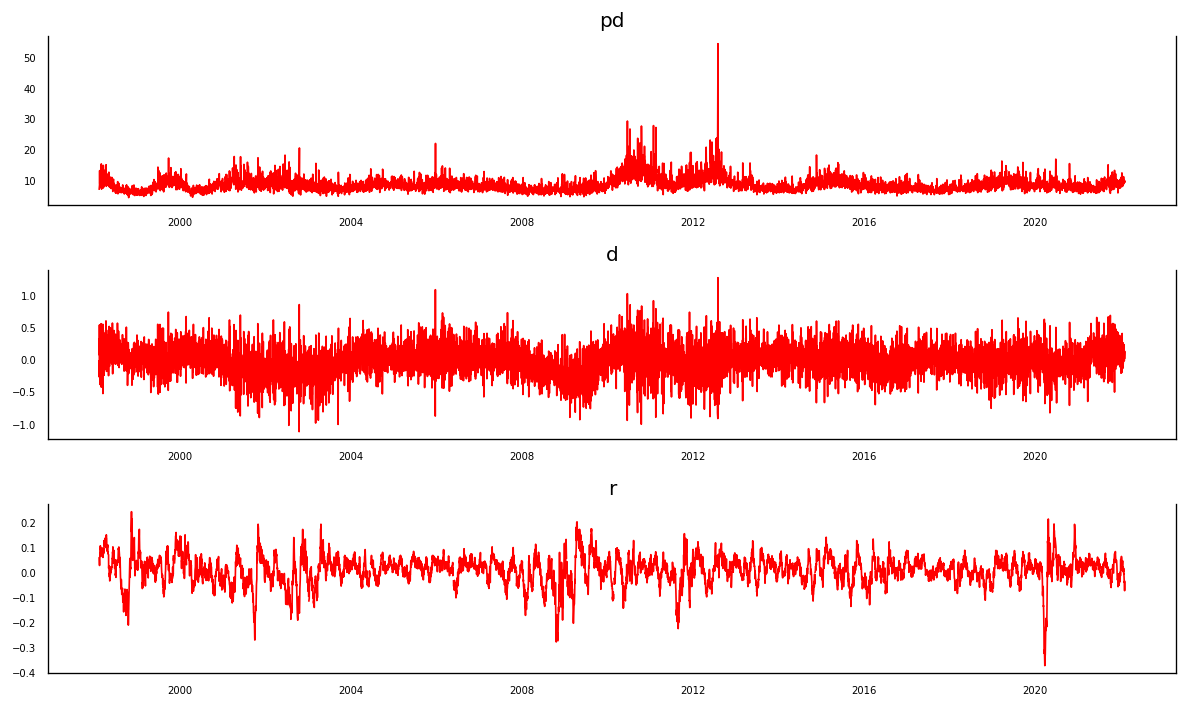

In [5]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[['pd', 'd', 'r']][df[['pd', 'd', 'r']].columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df[['pd', 'd', 'r']].columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

For now I can't say that the series have a similar trend patterns over the years. 

The next step in the analysis is to check for causality amongst these series. The Granger’s Causality test and the Cointegration test can help with that.

#### Granger causality

In [6]:
# get rid of other columns for now
full_df = df
df = df[['pd', 'd', 'r']]

In [7]:
# work with nan values
# I interpolate missing values in r
df = df.interpolate(limit=2, limit_direction="forward")

# I remove the first row as d is missing in the first period
df = df.iloc[1: , :]

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,pd_x,d_x,r_x
pd_y,1.0000,0.000,0.0259
d_y,0.0000,1.000,0.0000
r_y,0.4859,0.322,1.0000


The row are the Response (Y) and the columns are the predictor series (X). 

For example, if you take the value 0.000 in (row 1, column 2), it refers to the p-value of d_x causing pd_y. Whereas, the 0.4859 in (row 1, column 3) refers to the p-value of r_y causing pd_x.

So, we can conclude from the following table that r doesn't G cause pd or d. At the same time pd and d G cause r at 5% significance level.

Let's do cointegration test now.

#### Cointegration test

In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
pd     ::  233.0     > 24.2761   =>   True
d      ::  45.84     > 12.3212   =>   True
r      ::  4.29      > 4.1296    =>   True


We see that all time series are cointegrated. That means they have a long run, statistically significant relationship.

#### Stationarity

In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [11]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1449
 No. Lags Chosen       = 31
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0008. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "d" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3304
 No. Lags Chosen       = 18
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0136. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "r" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


All of the time series are already stationary.

Now let's split the data into test and train to assess how the forecasting model behaves.

#### Train test split


In [12]:
nobs = 9
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(6251, 3)
(9, 3)


#### Select the Order (P) of VAR model

In [13]:
df_train.index = pd.DatetimeIndex(df_train.index).to_period('d')

In [14]:
model = VAR(df_train)
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,-6.982,-6.979,0.0009282,-6.981
1,-10.46,-10.45,2.866e-05,-10.46
2,-10.86,-10.83,1.931e-05,-10.85
3,-11.17,-11.14,1.407e-05,-11.16
4,-11.44,-11.40,1.077e-05,-11.42
5,-11.58,-11.53,9.355e-06,-11.56
6,-11.68,-11.62,8.481e-06,-11.66
7,-11.74,-11.67,7.957e-06,-11.72
8,-11.80,-11.72,7.509e-06,-11.77
9,-11.82,-11.73*,7.324e-06,-11.79


I will choose P=9 as BIC suggests. 

#### Train the VAR Model of Selected Order(p)

In [15]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Aug, 2022
Time:                     15:29:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.7349
Nobs:                     6242.00    HQIC:                  -11.7941
Log likelihood:           10420.6    FPE:                7.31510e-06
AIC:                     -11.8256    Det(Omega_mle):     7.21754e-06
--------------------------------------------------------------------
Results for equation pd
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.955743         0.117253            8.151           0.000
L1.pd         0.106640         0.031915            3.341           0.001
L1.d         -0.121212         0.330907           -0.366           0.714
L1.r         -0.126507

#### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [16]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df_train.columns, out):
    print(adjust(col), ':', round(val, 2))

pd     : 2.01
d      : 2.01
r      : 2.0


The serial correlation seems quite alright. Let’s proceed with the forecast.

#### Forecast

In [17]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_forecast')
df_forecast['r_forecast']

date
2022-01-26    0.001315
2022-01-27    0.001306
2022-01-28    0.002163
2022-01-29    0.001960
2022-02-01    0.001797
2022-02-02    0.001818
2022-02-03    0.002577
2022-02-04    0.002333
2022-02-05    0.002586
Name: r_forecast, dtype: float64

Here I predicted last 9 periods (that were not used for training) using the model. Let's visualize the results. 

#### Plot of Forecast vs Actuals

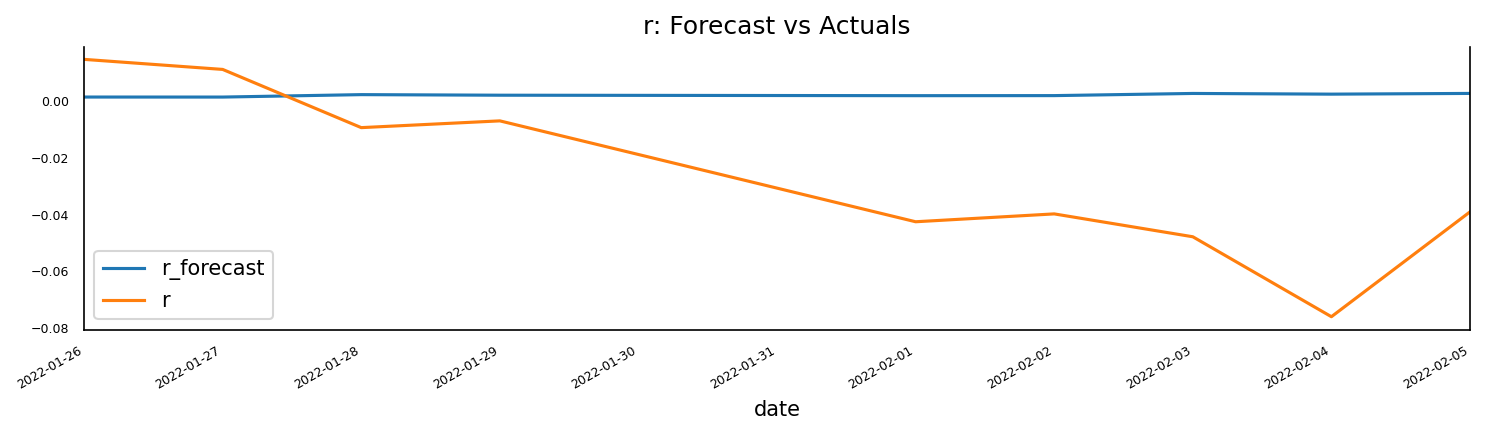

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(10,3))
df_forecast['r_forecast'].plot(legend=True, ax=axes).autoscale(axis='x',tight=True)
df_test[col][-nobs:].plot(legend=True, ax=axes);
axes.set_title(col + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)


plt.tight_layout();

In [19]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: r')
accuracy_prod = forecast_accuracy(df_forecast['r_forecast'].values, df_test['r'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: r
mape   :  1.0596
me     :  0.0282
mae    :  0.0333
mpe    :  -1.0596
rmse   :  0.0402
corr   :  -0.7153
minmax :  14.2769


C:\Users\77774\AppData\Local\Temp/ipykernel_6508/2350730256.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\77774\AppData\Local\Temp/ipykernel_6508/2350730256.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


## Part B: Asset allocation
### 1. Using expected return estimates from Part A to compute the time-series for the optimal portfolio decision $\alpha_t(k)$

In [20]:
# add forecast column to the full df
coef = model_fitted.params['r']
df['r_forecast'] = coef[0]+ coef[1]*df.pd.shift(1)  + coef[2]*df.d.shift(1)+ coef[3]*df.r.shift(1) + coef[4]*df.pd.shift(2)  + coef[5]*df.d.shift(2)+ coef[6]*df.r.shift(2) + coef[7]*df.pd.shift(3)  + coef[8]*df.d.shift(3)+ coef[9]*df.r.shift(3) + coef[10]*df.pd.shift(4)  + coef[11]*df.d.shift(4)+ coef[12]*df.r.shift(4) + coef[13]*df.pd.shift(5)  + coef[14]*df.d.shift(5)+ coef[15]*df.r.shift(5) + coef[16]*df.pd.shift(6)  + coef[17]*df.d.shift(6)+ coef[18]*df.r.shift(6) + coef[19]*df.pd.shift(7)  + coef[20]*df.d.shift(7)+ coef[21]*df.r.shift(7) + coef[22]*df.pd.shift(8)  + coef[23]*df.d.shift(8)+ coef[24]*df.r.shift(8) + coef[25]*df.pd.shift(9)  + coef[26]*df.d.shift(9)+ coef[27]*df.r.shift(9)
full_df = pd.concat([full_df.drop(['r'], axis=1), df[['pd', 'd', 'r', 'r_forecast']]], axis=1)

df = full_df.dropna(subset = ["sigma"])


In [21]:
# I interpolate missing values in rf
df['rf']= np.where( df.rf<-2, np.nan, df.rf)
df.rf = df.rf.interpolate(limit=2, limit_direction="forward")


$$ R_{p,t} \equiv \alpha_t R_t + (1 − \alpha_t)R_{f,t}$$

$$ \alpha_t = \frac{E_t[R_t] - R_{f,t} }{k\sigma^2_t} $$

In [22]:
def portfolio_return(k):
    df['alpha'] = (df.r_forecast - df.rf )/(k*df.sigma*df.sigma)
    df['r_p'] = df.alpha*df.r + (1 - df.alpha)*df.rf 
    
# choose k
portfolio_return(4)
df

,h,v,rf,sigma,pd,d,pd,d,r,r_forecast,alpha,r_p
date,,,,,,,,,,,,
1999-02-09,0.265325,0.069060,0.323689,0.057084,5.447025,0.260645,5.447025,0.260645,-0.021283,0.029722,-22.553371,8.103980
1999-02-10,0.248024,0.064860,0.322932,0.090580,5.813693,-0.002303,5.813693,-0.002303,-0.034798,-0.011444,-10.188443,3.967648
1999-02-11,0.271642,0.075476,0.321572,0.069738,5.482507,0.131417,5.482507,0.131417,-0.067520,-0.028767,-18.008879,7.328672
1999-02-12,0.269619,0.073859,0.310020,0.090774,5.485589,0.070696,5.485589,0.070696,-0.045575,-0.055914,-11.102422,4.257987
1999-02-13,0.264096,0.082827,0.298953,0.090894,5.973561,-0.005644,5.973561,-0.005644,-0.041374,-0.046341,-10.448711,3.854934
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,0.178304,0.067787,-0.005573,0.056470,9.661689,-0.026695,9.661689,-0.026695,-0.042527,-0.005323,0.019559,-0.006296
2022-02-02,0.194420,0.077617,0.003521,0.057842,9.225908,0.120905,9.225908,0.120905,-0.039765,-0.032751,-2.710314,0.120839
2022-02-03,0.178116,0.069139,0.000203,0.059506,9.810701,0.005396,9.810701,0.005396,-0.047804,-0.036420,-2.585642,0.124331


### 2. Plotting the average portfolio $E[R_{p,t}]$ return and the volatility $Var(R_{p,t})$ as a function of $k$

In [24]:
df.describe()

,h,v,rf,sigma,pd,d,pd,d,r,r_forecast,alpha,r_p
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.102788,-0.018280,0.121619,0.069842,8.537301,-0.023314,8.537301,-0.023314,0.005237,0.005294,-6.539811,2.381665
std,0.105276,0.094036,0.147997,0.027020,2.327011,0.249703,2.327011,0.249703,0.056472,0.052068,11.532848,3.741242
min,-0.197034,-0.302599,-0.061559,0.027157,4.440278,-1.124892,4.440278,-1.124892,-0.376489,-0.341960,-56.781997,-0.108863
25%,0.024836,-0.081309,-0.021516,0.051292,7.053862,-0.172669,7.053862,-0.172669,-0.022898,-0.020349,-12.782077,0.112599
50%,0.120684,0.001093,0.076561,0.064309,8.068872,-0.013337,8.068872,-0.013337,0.010853,0.010896,-3.227347,0.573274
75%,0.178701,0.047708,0.250621,0.079703,9.411225,0.135386,9.411225,0.135386,0.039114,0.036548,1.695402,3.176177
max,0.406503,0.277510,0.490552,0.248792,54.194632,1.265268,54.194632,1.265268,0.211338,0.188229,22.434600,32.017698


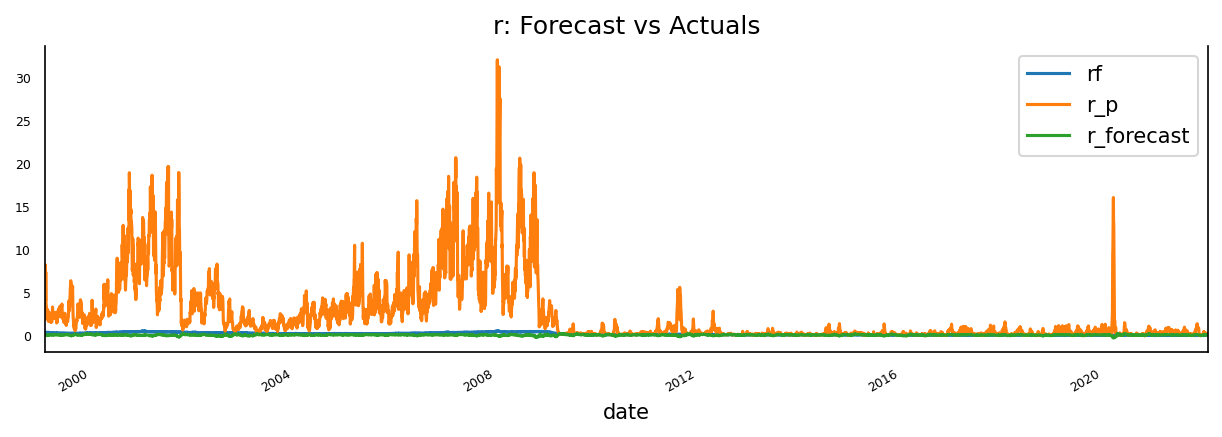

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(10,3))
df['rf'].plot(legend=True, ax=axes).autoscale(axis='x',tight=True)
df['r_p'].plot(legend=True, ax=axes).autoscale(axis='x',tight=True)
df['r_forecast'].plot(legend=True, ax=axes).autoscale(axis='x',tight=True)
axes.set_title(col + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

In [25]:
df.describe()

,h,v,rf,sigma,pd,d,pd,d,r,r_forecast,alpha,r_p
count,5995.000000,5995.000000,6000.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000
mean,0.102786,-0.018282,0.121619,0.069852,8.537351,-0.023344,8.537351,-0.023344,0.005217,0.005267,-6.530362,2.379794
std,0.105293,0.094048,0.147997,0.027024,2.327454,0.249777,2.327454,0.249777,0.056465,0.052051,11.525615,3.740336
min,-0.197034,-0.302599,-0.061559,0.027157,4.440278,-1.124892,4.440278,-1.124892,-0.376489,-0.341960,-56.781997,-0.108863
25%,0.024765,-0.081317,-0.021516,0.051304,7.054400,-0.172684,7.054400,-0.172684,-0.022905,-0.020371,-12.760179,0.112406
50%,0.120728,0.001034,0.076561,0.064311,8.068975,-0.013402,8.068975,-0.013402,0.010870,0.010884,-3.225129,0.572638
75%,0.178708,0.047718,0.250621,0.079704,9.410487,0.135524,9.410487,0.135524,0.039122,0.036506,1.696819,3.170255
max,0.406503,0.277510,0.490552,0.248792,54.194632,1.265268,54.194632,1.265268,0.211338,0.188229,22.434600,32.017698
